## Time-Dependent Perturbation Simulations

This is a Jupyter notebook which will illustrate a few examples of time-dependent perturbations to Hamiltonians.

We have learned to study these using time-dependent perturbation theory, where we assume that a perturbing Hamiltonian $\delta H$ is small, so that to first order, the coefficient of the $m$th basis vector starting from an energy eigenstate $n$ at time $0$ looks like

$$c_m^{(1)}(t) \, \, \tilde{} \int_0^t \, dt \, \delta H_{mn} e^{i \omega_{ma} t'} ,$$

where $\delta H_{mn} = \langle m \, | \, \delta H \, | \, n \rangle$ is the $m, n$ matrix element of the perturbation and $\omega_{ma} = \frac{E_m - E_n}{\hbar}$.

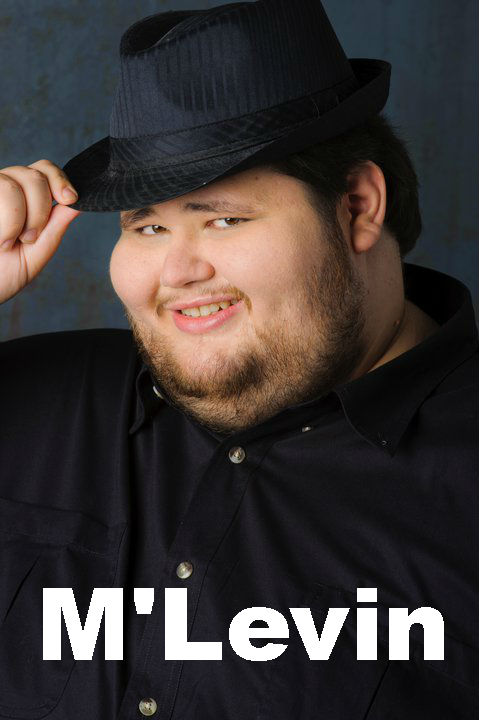

In [14]:
"""
One can extract useful insights from studying this analytically. 
Let's recall some of the punchlines that Michael told us about in lecture.
"""

from IPython.display import Image
Image("/home/ferko/Documents/fedora.jpg", retina=True)

__Punchlines.__
+ Sinusoidal perturbations $\delta H = V \sin ( \omega t )$ induce transitions as $$P_{a \rightarrow b}(t) \, \, \tilde{} \frac{V_{ab}}{\hbar^2} \frac{ \sin^2 \left[ \frac{ ( \omega_0 - \omega) t }{2} \right] }{ \left( \omega_0 - \omega \right)^2}. $$ In particular, we see "resonance" as the driving frequency is close to the natural frequency $\omega_0 = \frac{E_a - E_b}{\hbar}$!

+ This reduces to things we already understand in various limits!
 * Say the Hamiltonian $\delta H$ changes on a time scale $\tau$ which is large compared to the natural time scale for the unperturbed system, $\frac{\hbar}{E_a - E_b}$. Then the transition probabilities go to zero! This is a manifestation of the *adiabatic theorem* -- if you drag the Hamiltonian from one place to another slowly, you drag a system from the $n$-th eigenstate of the beginning Hamiltonian to the $n$-th eigenstate of the final Hamiltonian slowly (up to phase!). Very interesting physics here! Look up geometrical phase and dynamical phase, for example.
 * Say the time scale for the Hamiltonian, $\tau$, is very small compared to other time scales in the problem. Then the transition amplitudes again go to zero! The perturbation is "too fast" for the system to react.
 * Finally, what if we ignore the time dependence and look at the matrix elements $\delta H_{ab}$. If those guys vanish, then the transition amplitude will be zero, unconditional on the driving frequency. This is the idea of a *selection rule*, and often reflect deep symmetries of the problem. For example, in hydrogen, an electric field can only induce transitions where $L_z$ changes by $1$ unit, to first order, since the photon is a spin one particle!
 
Cool!

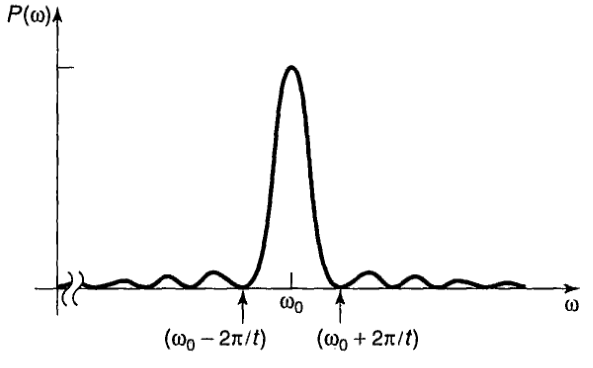

In [13]:
Image("/home/ferko/Documents/transition.png")

Motivated by these results, can we look at some more complicated time-dependent perturbations -- especially those that cannot be solved analytically -- to test and strengthen our intuition? That will be our goal for today.

*Learning Goals*.
* Get an introduction to QuTiP, the quantum toolbox in Python, for simulating quantum mechanical systems.
* Investigate two perturbations to the ordinary spin Hamiltonian $H = \begin{bmatrix} \epsilon & \Delta \\ \Delta & - \epsilon \end{bmatrix}$.
* Relate our simulation results back to general take-aways about time-dependent perturbations.

Let's do some physics!

In [1]:
"""
We'll use a Python library called QuTiP for our simulations. First I do some imports.
"""
import matplotlib.pyplot as plt, numpy as np
from qutip import *
%matplotlib inline

QuTiP has built-in data types for common objects in quantum mechanics, like the spin operators. Let's build a spin Hamiltonian $H = \begin{bmatrix} \epsilon & \Delta \\ \Delta & - \epsilon \end{bmatrix}$.

In [4]:
delta = 1
eps = 1

sx = sigmax(); sz = sigmaz()
H0 = - delta * sx - eps * sz

## Let's see how QuTiP represents H0

H0

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[-1. -1.]
 [-1.  1.]]

Wow! Notice that QuTiP automatically converted that bad boy to LaTeX behind the scenes! To get some familiarity, let's check out a few of the basic convenience functions we have for the "Quantum object" datatype.

In [19]:
## Get some daggers up in here

(H0 + sigmay()).dag()

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[-1.+0.j -1.-1.j]
 [-1.+1.j  1.+0.j]]

In [18]:
## Trace that sucker!

H0.tr()

0.0

In [17]:
## Compute the energies. Should be sqrt(2) and -sqrt(2), right?

H0.eigenenergies()

array([-1.41421356,  1.41421356])

In [14]:
## Find the eigenstates as numpy arrays!

H0.eigenstates()

(array([-1.41421356,  1.41421356]),
 array([ Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
 Qobj data =
 [[-0.92387953]
  [-0.38268343]],
        Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
 Qobj data =
 [[-0.38268343]
  [ 0.92387953]]], dtype=object))

In [16]:
## Get the commutator with sigma(y). What do you think it should be?

commutator(H0, sigmay())

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.-2.j  0.+2.j]
 [ 0.+2.j  0.+2.j]]

In [20]:
## Can also tensor with the identity, in case we had a composite state

tensor(H0, qeye(2))

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[-1.  0. -1.  0.]
 [ 0. -1.  0. -1.]
 [-1.  0.  1.  0.]
 [ 0. -1.  0.  1.]]

QuTiP has __many__ builtins for everything from harmonic oscillator raising and lowering states, to density matrices, to entangled multiparticle systems. It'll also do all of the time evolution for you!

I don't want to get carried away since we're talking about time dependence today. But as a last introduction, let's see how we could time evolve a state that evolves along $H_0$.

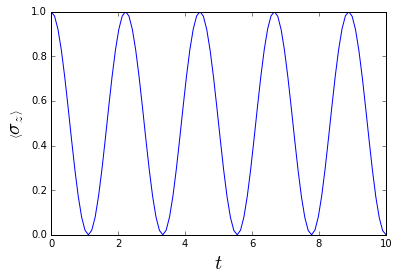

In [21]:
# initial state in the 0 direction of a 2x2 basis, i.e. | + >_x
psi0 = basis(2, 0)

# list of times for which the solver should store the state vector
tlist = np.linspace(0, 10, 100)

result = mesolve(H0, psi0, tlist, [], [])

fig, axes = plt.subplots(1,1)

axes.plot(tlist, expect(sigmaz(), result.states))

axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r'$\left<\sigma_z\right>$', fontsize=20);

Wow! Okay, now let's step things up a notch.

__Time-Dependent Example A__.

We're going to build a *tremendous* Stern-Gerlach experiment (and make the electrons pay for it).

Say we shoot electrons into the apparatus which are initially *all pointing along $| + , z \rangle$*. Let's also assume our magnetic field is constant in space, unlike the ordinary Stern Gerlach, with nonvanishing components along $x$ and $z$. We shoot the electron through and see how many electrons come out pointing up or down.

* Quick check.
 * Concept question: For fixed apparatus length, does the proportion of final $| + , z \rangle$ and $| - , z \rangle$ states depend on the speed of the electron beam?
 * Concept question: If some electrons start in $|+, z \rangle$ eigenstates and leave in $|-, z \rangle$ eigenstates that have higher energy, that energy had to come from somewhere. Did we break energy conservation?

Cool, now let's add a perturbation which depends *linearly* on time. That is, we're going to __jack up__ the strength of $B_z$ as the electron is going through the apparatus.

In [70]:
def tremendous_sg(delta, eps, A, psi0, tlist, osc=False, w = None, relax=False):
    """Compute the time evolution in the tremendous Stern-Gerlach
    
    Args:
        delta: the off-diagonal piece of the unperturbed Hamiltonian
        eps: the \sigma_z component of H0
        A: coefficient of the time-independent piece of the perturbing Hamiltonian
        psi0: the initial state
        tlist: an iterable of floats giving times at which H should be computed
        osc: if True, make the field oscillate instead of increasing linearly in time
        w: if osc is true, this is the angular frequency of oscillation
        relax: if True, make excited states naturally fall back down to the ground state over time
        
    Returns:
        array of expectation value of \sigma_z at times in tlist
    """
    # Let's get the pieces to build our Hamiltonian at any time
    sx = sigmax()
    sz = sigmaz()

    H0 = - delta * sx - eps * sz
    H1 = - A * sz

    ## At the end of the day, we collapse with a measurement of the z basis state
    
    meas = destroy(2)
    
    if relax:
        collapse_operators = [np.sqrt(0.1) * meas]
    else:
        collapse_operators = []
    if osc:
        H = [H0, [H1, lambda x,y: np.sin(w*x)]]
    else:
        H = [H0, [H1, 't']]
    output = mesolve(H, psi0, tlist, collapse_operators, [meas.dag() * meas], {})
    
    return output.expect[0]

In [65]:
## Here we choose numerical parameters

delta = 0.5 * np.pi
eps0  = 0.0 * np.pi
A     = 2.0 * np.pi   # peturbation growth rate
psi0 = basis(2,0)      # initial state

tlist = np.linspace(-20.0, 20.0, 5000)

p_ex = tremendous_sg(delta, eps0, A, psi0, tlist)

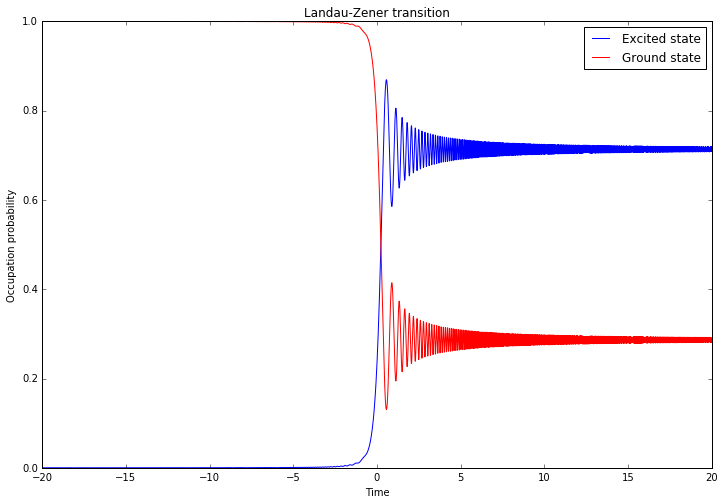

In [66]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(tlist, np.real(p_ex), 'b', tlist, np.real(1-p_ex), 'r')
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')
ax.set_title('Landau-Zener transition')
ax.legend(("Excited state", "Ground state"), loc=0);

Wow! Let's dig in a little.

__Wait, this doesn't make sense. I rememb?er from lecture that the coefficients under a time perturbation go like $c_m(t) \, \, ~ \int_0^t dt' \delta H_{mn} e^{i \omega_ma t'}$. But here the off-diagonal elements $\delta H_{mn}$ are zero, since the perturbing Hamiltonian is purely diagonal! So we should have a selection rule that says *nothing* happens!__

What's wrong with this reasoning

__Okay, maybe there's no selection rule and this thing doesn't vanish. But looking again at the expression for $c_m(t)$, at negative times, this looks like $\int_0^t dt' A t' (\sigma_z)_{mn} e^{i \omega_{ma} t'}$, where I think $\omega_ma$ should be pretty big. Therefore at negative times I should get huge amplitude oscillations ($|A|$ is big) with a high frequency.__

What goes wrong now?

__The perturbing Hamiltonian $\delta H = A \sigma_z t$ is antisymmetric in time -- if I flip $t$ to $-t$, everything is the same up to a sign. Therefore the plot of probabilities should be symmetric in time, although possibly with the probabilities inverted before and after $t=0$. So why is the right side of the plot oscillator whereas the left side looks flat?__

What breaks the symmetry here?

__What would happen if we changed the "background" field along $z$ by setting $\epsilon \neq 0$? Will the crossover point in the above graph still occur at time $t=0$? Earlier? Later?__

Please vote by thumb! ^_^

__Why does the amplitude of the oscillations die down over time? Why does the speed of oscillations get faster?__

What do you think?

For my last trick, let's make our *tremendous* Stern-Gerlach more interesting.

Rather than change the field strength linearly in time, let's try a sinusoidal oscillation.

$$\delta H = \sigma_z \sin ( \omega t )$$.

Now what happens?

In [67]:
w = 1.0
tlist = np.linspace(-20.0, 20.0, 5000)

p_ex_osc = tremendous_sg(delta, eps0, A, psi0, tlist, w=w, osc=True)

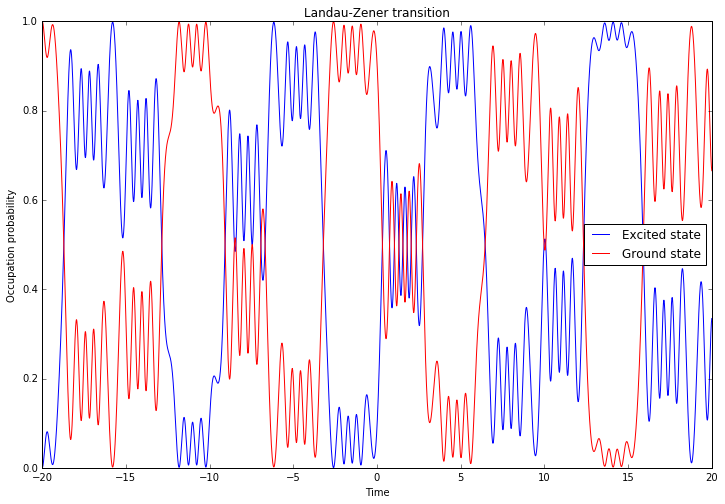

In [68]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(tlist, np.real(p_ex_osc), 'b', tlist, np.real(1-p_ex_osc), 'r')
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')
ax.set_title('Landau-Zener transition')
ax.legend(("Excited state", "Ground state"), loc=0);

Now we never die down to a "steady state" configuration?

What if we let the spins naturally relax from the excited state back down to the ground state (by emitting a photon, for example)?

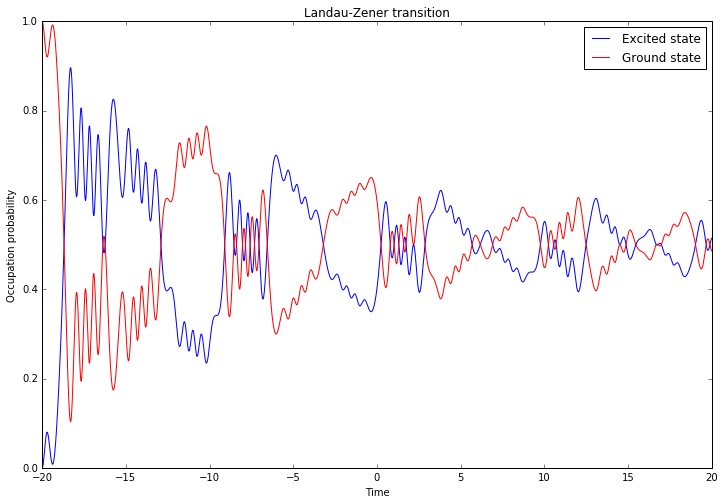

In [71]:
p_ex_relax = tremendous_sg(delta, eps0, A, psi0, tlist, w=w, osc=True, relax=True)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(tlist, np.real(p_ex_relax), 'b', tlist, np.real(1-p_ex_relax), 'r')
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')
ax.set_title('Landau-Zener transition')
ax.legend(("Excited state", "Ground state"), loc=0);

Wow! It looks like the probabilities eventually settle down once we add in the natural relaxation.

For our last trick, let's see how this "steady state" probability depends on the parameters, namely the size $A$ of the perturbation, the frequency $\omega$, and how much of the unperturbed Hamiltonian is along $S_z$ (measured by $\epsilon$).

In [85]:
A_vec    = np.linspace(0.0, 4.0, 100) * 2 * np.pi  # driving amplitude
eps_vec = np.linspace(0.0, 4.0, 100) * 2 * np.pi  # how much B_z
w=1.0

def get_eq_array(delta, eps_vec, A_vec, w):
    """Gets the equilibrium probabilities for various A and epsilon
    
    Args:
        delta: the off-diagonal piece of the unperturbed Hamiltonian
        eps: the \sigma_z component of H0
        A: coefficient of the time-independent piece of the perturbing Hamiltonian
        psi0: the initial state
        w: angular frequency of oscillation
        
    Returns:
        2d array of equilibrium probabilities
    """
    sx = sigmax()
    sz = sigmaz()
    meas = destroy(2)
    sn = meas.dag() * meas
    
    ## At the end of the day, we collapse with a measurement of the z basis state

    collapse_operators = [np.sqrt(0.1) * meas]

    N = len(A_vec)
    M = len(eps_vec)
    p_ex = np.zeros([N, M])

    T = 2 * np.pi / w

    ## Iterate over the A and epsilon values, get the equilibrium
    ## probabilities, and squirrel them away in a matrix
    for n in range(0, N):
        for m in range(0, M):

            H0 = - delta/2.0 * sx - eps_vec[m]/2.0 * sz
            H1 = - A_vec[n] * sx
        
            H_args = (H0, H1, w)

            # find the propagator for one period of the time-dependent
            # hamiltonian
            H = [H0, [H1, lambda x,y: np.sin(w*x)]]
            U = propagator(H, T, collapse_operators, {})

            # find the steady state of the driven system 
            rho_ss = propagator_steadystate(U)
        
            p_ex[n, m] = np.real(expect(sn, rho_ss))

    return p_ex

p_ex = get_eq_array(delta, eps0_vec, A_vec, w)

KeyboardInterrupt: 

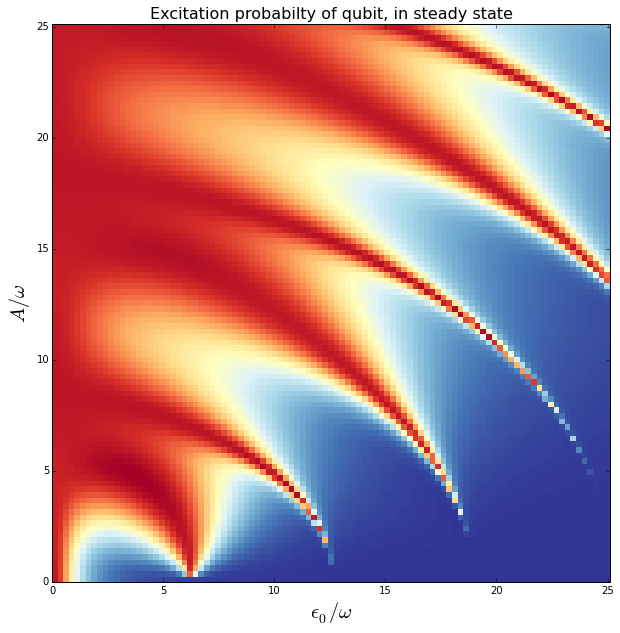

In [88]:
from IPython.display import Image
Image("/home/ferko/Documents/ex_prob.png")